# Spatial Interpolation with ESI on Non-gridded Data

Spatialize supports two formats formats for input data. This document provides an overview on the implementation for non-gridded data.

In [1]:
# === Libraries ===
import sys
sys.path.append('../')
from utils import SyntheticScenario

# Importar ESI desde repositorio, no desde instalación python, borrar antes de publicar!!
import import_helper
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

import numpy as np
from matplotlib import pyplot as plt
from spatialize.viz import PlotStyle
from mpl_toolkits.axes_grid1 import make_axes_locatable

import spatialize.gs.esi.aggfunction as af
from spatialize.gs.esi import esi_nongriddata
from sklearn.metrics import mean_absolute_error

## Non-gridded data

The ``esi_nongriddata()`` function is designed to produce estimations over any array of coordinates.

In the 2-D scenario, the shape of this array is $(N_x \times D)$, where $N_x$ is the number of points where estimations are to be made and $D$ is the dimensionality of the data.

A regular grid of this format can be created as follows:

In [2]:
# Parameters: 100x150 "grid"
x_min, x_max, n_x = 1, 100, 100
y_min, y_max, n_y = 1, 150, 150

# Array of coordinates
x_coordinates = np.linspace(x_min, x_max, n_x)
y_coordinates = np.linspace(y_min, y_max, n_y)
xi = np.array([(x, y) for x in x_coordinates for y in y_coordinates])

print(xi.shape)

(15000, 2)


> Note: The points do not have to form a regular grid. Here, we use a grid to ease visualization of results.

> Note 2: Currently suported local interpolator-partition process combinations for non-gridded data are:
- 'idw' as local interpolator and 'mondrian' as partition process supports up to 5-dimensional data
- 'idw' as local interpolator and 'voronoi' as partition process supports 2-dimensional data
- 'kriging' as local interpolator and 'mondrian' as partition process supports 2-dimensional data

## Producing ESI Estimates
Now, we will produce ESI estimates over two synthetic scenarios:

- **Scenario (a)**: a regular grid
- **Scenario (b)**: an incomplete grid, for which a corner of the grid in scenario (a) will be removed

> Note: Scenario (b) represents a case which would not be possible to replicate using traditional gridded data.

### Creating Synthetic Scenarios
We'll use a sort of cubic function to generate synthetic samples.

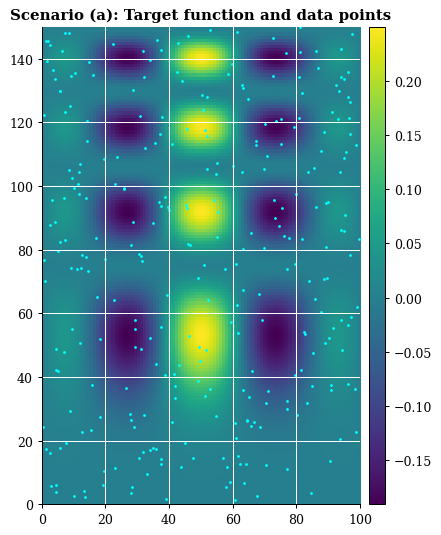

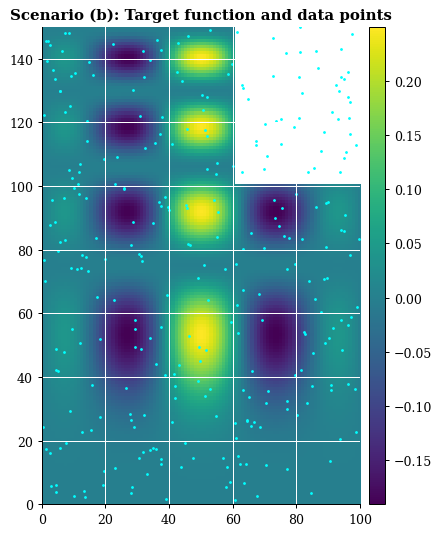

In [3]:
# === Scenario (a): Regular "grid" ===
scenario = SyntheticScenario(n_dims=2, extent=[0, 100, 0, 150], griddata=False)
points, values, xi, reference_values = scenario.simulate_scenario(n_samples=300, seed=42)

# Visualize reference values and samples
scenario.plot_2d_scenario(points, xi, reference_values,
                          theme='publication', figsize=(5, 8),
                          dpi=90, point_color='cyan',
                          title = 'Scenario (a): Target function and data points')
plt.tight_layout()
plt.show()

# === Scenario (b): Incomplete grid === 
mask = (xi[:,0]<=60) | (xi[:,1]<=100)
xi_2 = xi[mask]
ref_2 = reference_values[mask]
ref_masked = reference_values.copy()
ref_masked[~mask] = np.nan

scenario.plot_2d_scenario(points, xi, ref_masked,
                          theme='publication', figsize=(5, 8),
                          dpi=90, point_color='cyan',
                          title = 'Scenario (b): Target function and data points')
plt.tight_layout()
plt.show()

### Producing Estimates

Next, we employ the ``esi_griddata`` function to produce the estimates. Here, we will use inverse distance weighting (IDW) as local interpolator.

In [4]:
# Run ESI
result = esi_nongriddata(points, values, xi,
                         local_interpolator="idw",
                         p_process="mondrian",
                         exponent=1.0,
                         n_partitions=300, alpha=0.985,
                         agg_function=af.mean
                         )

# Get estimates and their precision
esi_est = result.estimation()
esi_prec = result.precision()

finished 100% of 300 iterations ... 

done (elapsed time:  4s)


We can quickly visualize the results with the `quick_plot()` method:

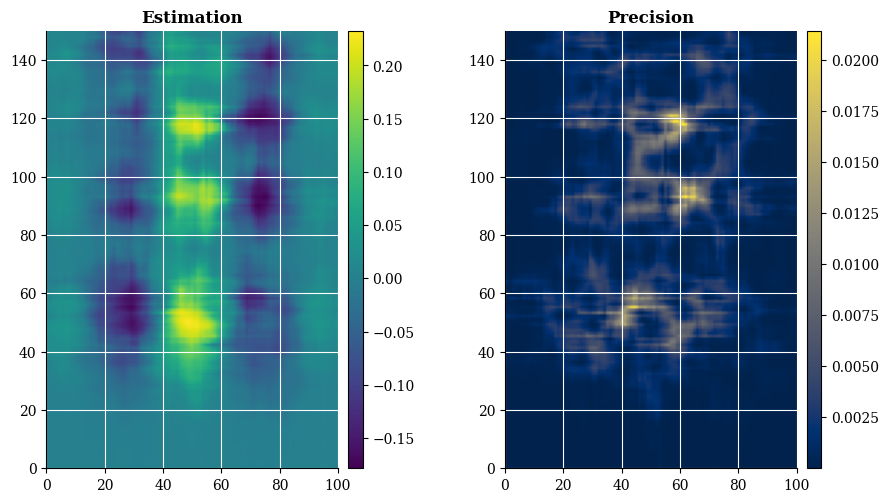

In [5]:
result.quick_plot(theme='publication', dpi=100)
plt.show()

Since we are using synthetic data, we can calculate performance metrics between the reference values and the estimated values:

In [6]:
print(f"MAE = {mean_absolute_error(reference_values, esi_est):.4f}")

MAE = 0.0185


Now, we will produce estimates for scenario (b).

In [7]:
# Run ESI
result_2 = esi_nongriddata(points, values, xi_2,
                           local_interpolator="idw",
                           p_process="mondrian",
                           exponent=1.0,
                           n_partitions=300, alpha=0.985,
                           agg_function=af.mean
                           )

# Get estimates and their precision
esi_est_2 = result_2.estimation()
esi_prec_2 = result_2.precision()

finished 100% of 300 iterations ... 

done (elapsed time:  3s)


We will now visualize the estimates and their precision.

> Note: the `quick_plot()` method is only available for data than can be reshaped into a regular grid.

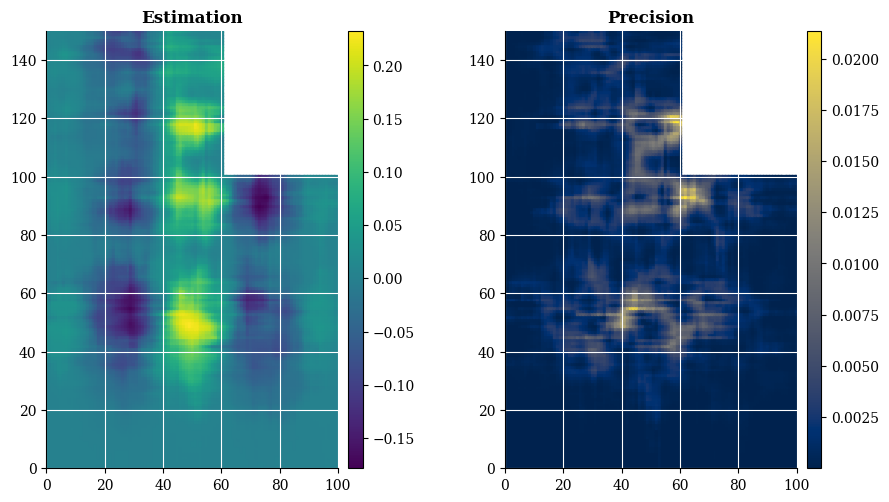

In [8]:
# We will use a scatterplot for a straighforward visualization

with PlotStyle(theme='publication') as style:
    fig = plt.figure(figsize = (10, 8))
    gs = fig.add_gridspec(1, 2, wspace=0.45)
    ax1, ax2 = gs.subplots()

    # Estimates
    ax1.set_title('Estimation')
    plot1 = ax1.scatter(xi_2[:,0], xi_2[:,1], c=esi_est_2, cmap=style.cmap, marker="s", s=4)

    # Precision
    ax2.set_title('Precision')
    plot2 = ax2.scatter(xi_2[:,0], xi_2[:,1], c=esi_prec_2, cmap=style.precision_cmap, marker="s", s=4)

    # Plot configuration
    for ax,plot in zip([ax1, ax2], [plot1, plot2]):
        ax.set_xlim(xi_2[:,0].min(), xi_2[:,0].max())
        ax.set_ylim(xi_2[:,1].min(), xi_2[:,1].max())
        ax.set_aspect('equal')

        # Colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cax.grid(False)
        plt.colorbar(plot, orientation='vertical', cax=cax)

plt.show()

Finally, we can calculate the mean absolute error:

In [9]:
print(f"MAE = {mean_absolute_error(ref_2, esi_est_2):.4f}")

MAE = 0.0185
